## 1. Air quality data preparation
### 1-1. Data extraction
### 해당 블락에서는 CSV나 자체 데이터에 대해서 불러오는 코드로 대체 하면 됩니다.

In [18]:
import sys, os
import pandas as pd
sys.path.append("../../../../")

In [19]:
from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_client_v2 as influx_Client
db_client = influx_Client.InfluxClient(ins.CLUSTDataServer2)
import missingno as msno

In [20]:
bucket_name ="air_indoor_초등학교"
ms_name ="ICW0W2000022" #ICW0W2000022, ICW0W2000033
clean_level_list =[0, 1, 2, 3, 4]
# ingestion
ingestion_type = "ms_all"
ingestion_param = {
    "bucket_name" : bucket_name,
    'ms_name' : ms_name                       
}
from Clust.clust.data import data_interface
#data = data_interface.get_data_result(ingestion_type, db_client, ingestion_param)[:100000]

In [21]:
ingestion_type = "ms_by_time"
ingestion_param['start_time'] = "2021-03-01 00:00:00"
ingestion_param['end_time']  ="2021-12-31 00:00:00"

from Clust.clust.data import data_interface
data = data_interface.get_data_result(ingestion_type, db_client, ingestion_param)
feature_list = data.columns

### 1-2. Original Data EDA

in_co2      0
in_humi     0
in_noise    0
in_pm01     0
in_pm10     0
in_pm25     0
in_temp     0
in_voc      0
dtype: int64


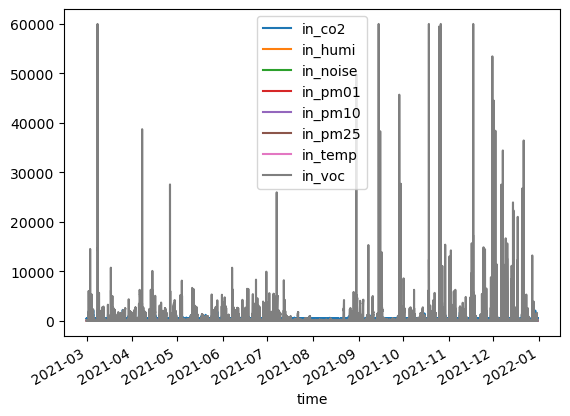

In [22]:
data.plot()
print(data.isna().sum())

## 2. Data Preprocessing
### 2-1. REFINEMENT
### 

In [23]:
# 1) 기본 REFINEMENT PARAMETER
refine_param = {
   "remove_duplication":{
      "flag":False
   },
   "static_frequency":{
      "flag":False
   }
}
refine_param

{'remove_duplication': {'flag': False}, 'static_frequency': {'flag': False}}

In [24]:
# 2) refinement중 Duplication에 대해 제거하고 싶을 경우
refine_param["remove_duplication"]["flag"]=True
# 3) refinement중 static frequency로 설정하고 싶을 경우
refine_param["static_frequency"]["flag"]=True
refine_param

{'remove_duplication': {'flag': True}, 'static_frequency': {'flag': True}}

In [33]:
# 3-1) Refinement에 대해 특정 frequency를 설정하고 싶을 경우
import datetime 
freq_min = 3
timedelta_frequency_min = datetime.timedelta(minutes= freq_min)
refine_param["static_frequency"]["frequency"]=timedelta_frequency_min
refine_param

{'remove_duplication': {'flag': True},
 'static_frequency': {'flag': True,
  'frequency': datetime.timedelta(seconds=180)}}

In [31]:
# 3-2) Refinement에 대해 Default로 frequency를 설정하고 싶을 경우
refine_param["static_frequency"]["frequency"]=None
refine_param

{'remove_duplication': {'flag': True},
 'static_frequency': {'flag': True, 'frequency': None}}

In [34]:
# 3-3) Parameter에 따른 최종 데이터 처리
from Clust.clust.preprocessing import processing_interface
refine_data = processing_interface.get_data_result('refinement', data , refine_param)

in_co2      592
in_humi     592
in_noise    592
in_pm01     592
in_pm10     592
in_pm25     592
in_temp     592
in_voc      592
dtype: int64


<Axes: xlabel='time'>

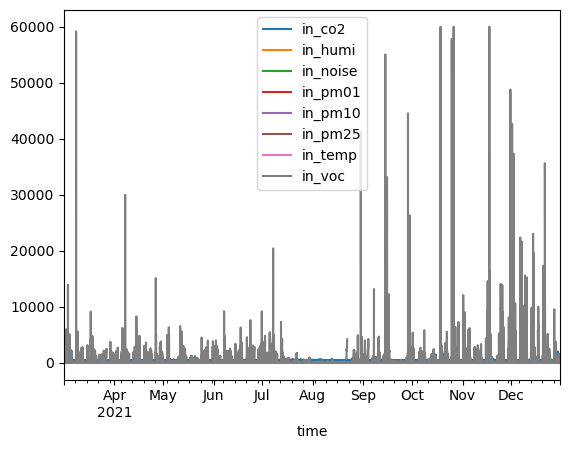

In [35]:
print(refine_data.isna().sum())
refine_data.plot()

### 2-2. Outlier Detection
#### 2-2-1. Certain Outlier Detection

In [ ]:
# 1) Outlier detection을 하기위한 parameter 정의 (min_max={} 가 default)
# 아래 코드는 CLUST 플랫폼 상에서 자동으로 min_max를 가져오는 코드로, 참고만 하세요.
from Clust.clust.meta.metaDataManager import bucketMeta
from Clust.clust.ingestion.mongo import mongo_client
mongo_client_ = mongo_client.MongoClient(ins.CLUSTMetaInfo2)
min_max = bucketMeta.get_min_max_info_from_bucketMeta(mongo_client_, bucket_name)
"""
#min_max 예제
min_max = {'max_num': {'in_pm01_raw': 1000},  'min_num': {'in_pm01_raw': 0}}
"""
min_max

In [ ]:
# 2) abnormal_value_list가 필요할 경우 
abnormal_value_list =[99.9, 199.9, 299.9, 9999, -99.9, -199.9, -299.9, -9999, -9999.0] 

In [ ]:
# 3) Parameter, flag가 False일 경우 처리되지 않으며, 각각의 값이 없을 경우 시스템의 디폴트 값을 가져올 수 있음
certain_param= {'flag': True, "anomal_value_list":abnormal_value_list, "data_min_max_limit":min_max}
certain_param

In [ ]:
# 4) 명확하게 이상 데이터에 대해서 NaN으로 처리함
more_certain_NaN = processing_interface.get_data_result('certain_error_to_NaN', refine_data, certain_param)

#### 2-2-2. UnCertain Outlier Detection

In [ ]:
# 1) UnCertain Param # uncertain parameter 설정은 다소 복잡함. 추가 예제로 테스트할 수 있으며, 이 테스트 파일에서는 기본 값에 대해 진행
Un_certain_param= {'flag': True, "anomal_value_list":abnormal_value_list, "data_min_max_limit":min_max}
Un_certain_param

In [ ]:
more_uncertain_nan = processing_interface.get_data_result('uncertain_error_to_NaN', more_certain_NaN, Un_certain_param)

In [ ]:
print(datawithMoreCertainNaN.isna().sum())
datawithMoreCertainNaN.plot()

In [ ]:
from Clust.clust.ingestion.mongo.mongo_client import MongoClient
from Clust.app import data_manipulation
from Clust.app import  data_preprocessing

mongo_client = MongoClient(ins.CLUSTMetaInfo2)

In [ ]:
ingestion_param={}
ingestion_param['start_time'] = "2021-02-01 00:00:00"
ingestion_param['end_time']  ="2021-03-10 00:00:00"
ingestion_param['ms_list_info'] = ingestion_param['ms_list_info'] = [['farm_swine_air', 'HS2'], ['weather_outdoor_keti_clean', 'sangju'], ['life_additional_Info', 'trigonometicInfoByHours']]  
###########################################
data_mode = 'trainX'
for clean_level in clean_level_list:
    # data name
    collection_name = data_purpose+ "_"+data_name
    ms_name = collection_name + '_cleanLevel' + str(clean_level)+'_' + data_mode
    process_param = data_manipulation.get_process_param_by_level(clean_level)
    # meta info
    meta_info={"bucket_name":bucket_name, "collection_name":collection_name, "ms_name": ms_name, 
               "ingestion_type": ingestion_type, "ingestion_param": ingestion_param, 
               "processing_type":processing_type, "process_param":process_param,
               "integration_param":integration_param, "clean_level":clean_level}
    data_manipulation.save_processed_integrated_data_meta(db_client, mongo_client, meta_info)

###########################################
ingestion_param['start_time']  ="2021-03-10 00:00:00"
ingestion_param['end_time']  ="2021-03-17 00:00:00"  
data_mode = 'testX'

for clean_level in clean_level_list:
    # data name
    collection_name = data_purpose+ "_"+data_name
    ms_name = collection_name + '_cleanLevel' + str(clean_level)+'_' + data_mode
    process_param = data_manipulation.get_process_param_by_level(clean_level)
    # meta info
    meta_info={"bucket_name":bucket_name, "collection_name":collection_name, "ms_name": ms_name,
               "ingestion_type": ingestion_type, "ingestion_param": ingestion_param, 
               "processing_type":processing_type, "process_param":process_param,
               "integration_param":integration_param, "clean_level":clean_level}
    data_manipulation.save_processed_integrated_data_meta(db_client, mongo_client, meta_info)